# Copter like device simulator development
 - These classes provides a dumb/greedy environment for developing copter like device controls
 - Currently revising version0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Transformer import Transformer
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
G = -9.81

In [4]:
"""Mark 0"""
# Gravitational constant
G = -9.81

class DeviceID():
    def __init__(self, configs, pose_0, v_0, a_0, memory_length=50):
        self.configs = configs
        self.path = {'poses' : np.array([pose_0]),
                    'velocities' : np.array([v_0]),
                    'accelerations' : np.array([a_0])}
        self.memory_length = memory_length

    def add_odom(self, new_val, tag=''):
        assert len(tag) > 1, 'Odometry tag unclear: \n\t use [accelerations, velocities, poses]'
        if len(self.path[tag]) < self.memory_length:
            self.path[tag] = np.concatenate([self.path[tag],[new_val]])
        else:
            self.path[tag] = np.concatenate([self.path[tag][1:],[new_val]])


class Aerial_Device():
    """ This class is used to perform forward kinematics of an N-copter device
            - only quadcopter is stable
            - needs serious tuning 
            - can always double check the math
    """
    def __init__(self, mass=40, max_O=500, motor_config=np.array([(.2,.2,0), (-.2,.2,0), (-.2,-.2,0), (.2,-.2,0)]), motor_rotation_effect=np.array([[-1,1,1,-1],[1,1,-1,-1],[1,-1,1,-1]]), memory_length=100, p=.01, b=-.3):
        self.net_force = np.array([0,0,G*mass,0,0,0]) # Needs to be in the earth frame where [0,0,0,0,0,0] is start pose
        self.velocity = np.zeros(6) # also in earth frame
        self.poseActual = np.zeros(6) # also in earth frame
        self.throttle = np.zeros(len(motor_config)) # rotations per second
        self.id = DeviceID({
            'mass' : mass,
            'max rpm' : max_O,
            'motor configuration' : motor_config,
            'rotational thrust' : motor_rotation_effect,
            'speed2thrust' : p,
            'vel2drag' : b,
            'length' : np.sqrt(motor_config[0][0]**2 + motor_config[0][1]**2)},
            self.poseActual,
            self.velocity,
            self.net_force / mass,
            memory_length=memory_length
            )
        self.control = Controller()

    def reset(self):
        self.net_force = np.array([0,0,G*self.id.configs['mass'],0,0,0]) # Needs to be in the earth frame where [0,0,0,0,0,0] is start pose
        self.velocity = np.zeros(6) # also in earth frame
        self.poseActual = np.zeros(6) # also in earth frame
        self.throttle = np.zeros(len(self.throttle)) # rotations per minute
        self.id.path['poses'] = np.array([self.poseActual])
        self.id.path['velocities'] = np.array([self.velocity])
        self.id.path['accelerations'] = np.array([self.net_force / self.id.configs['mass']])

    def wrap_angles(self, radians):
        return (radians + np.pi) % (2 * np.pi) - np.pi

    def set_throttles(self, speeds):
        for i,val in enumerate(speeds):
            self.throttle[i] = np.min([val, self.id.configs['max rpm']])

    def adjust_throttles(self, deltas=[]):
        for i,val in enumerate(deltas):
            self.throttle[i] = np.min([np.max([val + self.throttle[i], 0]), self.id.configs['max rpm']])

    def update_odometry(self, t=.005):
        """ forward kinematics pose update """
        self.update_net_force()
        self.update_velocity_and_pose(t)
        self.poseActual[3:] = self.wrap_angles(self.poseActual[3:])
        self.velocity[3:] = self.wrap_angles(self.velocity[3:])
        self.net_force[3:] = self.wrap_angles(self.net_force[3:])

    def update_velocity_and_pose(self, t):
        """ velocity and pose are updated based on the 
        net forces acting on the device and the cycle_time 
        both are in the earth frame"""
        # simple F -> v -> p kinematics
        for i,component in enumerate(self.net_force):
            a = component / self.id.configs['mass']
            self.poseActual[i] += a * (t**2) / 2 + (self.velocity[i] * t) # x(i) = x(i-1) + v(i-1)t + (at^2)/2
            self.velocity[i] += a * t                                       # v(i) = v(i-1) + at

        self.id.add_odom(self.velocity, tag='velocities')
        self.id.add_odom(self.poseActual, tag='poses')

    def update_net_force(self):
        """ Calculates the thrust wrt the inertial 
        frame of the motors then rotates into 
        earth frame. This function operates
        with the assumption that Ft ~ omega^2 * p"""
        p = self.id.configs['speed2thrust']
        b = self.id.configs['vel2drag']
        thrusts = np.array([self.throttle[0]**2*p,self.throttle[1]**2*p,self.throttle[2]**2*p,self.throttle[3]**2*p])

        # calculate the inertial thrust as proportional to sum(omega^2)
        torque = np.matmul(self.id.configs['rotational thrust'], thrusts)
        i_thrust = np.array([0, 0, np.sum(thrusts), torque[0] * self.id.configs['length'], torque[1] * self.id.configs['length'], torque[2]])

        # calculate the drag force (w.r.t the earth frame) as inversly proprotional to velocity
        drag = self.velocity * b
        # transform linear and angular thrusts, and store as new net_force
        self.net_force = np.concatenate([self.R(i_thrust[:3]),self.R(i_thrust[3:])]).reshape(6) + drag

        # dont forget about gravity
        self.net_force[2] += G * self.id.configs['mass']

        # record data for later analysis
        self.id.add_odom(self.net_force / self.id.configs['mass'],tag='accelerations')


In [6]:
# failing test case
ad = Aerial_Device()

NameError: name 'Controller' is not defined

In [20]:
""" Mark I"""
class Aerial_Device:
    def __init__(self, motor_positions, motor_orientations, motor_spin, mass, max_thrust, drag_coef, cycle_time=0.05):
        assert motor_positions.shape == motor_orientations.shape, f'Motor configuration is contradicting: {motor_positions.shape} != {motor_orientations.shape}' 
        assert len(motor_spin) == len(motor_positions), f'Motor spin and Motor positions do not algin: {len(motor_spin)} != {len(motor_positions)}'
        assert max_thrust > 0, f'Illegal Max Thrust Speed: {max_thrust} !> 0' # all motors must be identical for now
        assert mass > 0, f'Illegal Mass: {mass} !> 0'
        
        self.path = [[0], [0], [0]]
        self.mass = mass
        self.t = cycle_time
        self.autobots = None
        self.drag = drag_coef
        self.p = max_thrust / 10 # assuming ideal condiditons
        self.motor_spin = motor_spin
        self.max_thrust = max_thrust
        self.refActual = np.zeros(3)
        self.linearVel = np.zeros(3)
        self.poseActual = np.zeros(3)
        self.referenceVel = np.zeros(3)
        self.init_m_pose = motor_positions # motor positions relative to the body
        self.init_m_ref = motor_orientations # motor orientations relative to the body
        self.nMotors =  motor_positions.shape[0]
        self.throttleActual = np.zeros(self.nMotors)
        
        self.build_transformers()
        
    def wrap_angle(self, radians):
        return (radians + np.pi) % (2 * np.pi) - np.pi
        
    def build_transformers(self):
        # only needs to happen once if motors dont move w.r.t. the body frame
        # body frame is the devices reference to the world (maybe becomes adaptive someday)
        self.autobots = [Transformer(self.refActual[0], self.refActual[1], self.refActual[2], 'Body', translation=self.poseActual)]
        for i in range(self.nMotors):
            self.autobots.append(Transformer(self.init_m_ref[i,0], self.init_m_ref[i,1], self.init_m_ref[i,2], f'Motor{i}', translation=self.init_m_pose[i], parent=self.autobots[0]))
            
    def get_net_force(self):
        lin_thrust =  np.zeros(3)
        torque = np.zeros(3)
        # find the linear thrust and torque of each motor
        for i, throttle in enumerate(self.throttleActual):
            thrust = throttle**2 * self.p
            d = np.linalg.norm(self.init_m_pose[i])
            lin_thrust += self.autobots[i+1].transform(np.array([0.0, 0.0, thrust]), inverse=True) + (self.drag * self.linearVel)
            torque += self.autobots[i+1].transform(np.array([-thrust * d, 0.0, thrust * self.motor_spin[i]]), inverse=True) + (self.drag * self.referenceVel)
        return lin_thrust + (0.0, 0.0, G * self.mass), torque
    
    def update_odometry(self, t=-1):
        if t == -1:
            t = self.t
            
        lin_thrust, torque = self.get_net_force()
        lin_accel = lin_thrust / self.mass
        ang_accel = torque / self.mass
        self.poseActual += (self.linearVel * t) + (lin_accel * (t**2) / 2)
        self.refActual += (self.referenceVel * t) + (ang_accel * (t**2) / 2)
        self.linearVel += lin_accel * t
        self.referenceVel += ang_accel * t
        for i in range(len(self.refActual)):
            self.refActual[i] = self.wrap_angle(self.refActual[i])
            self.referenceVel[i] = self.wrap_angle(self.referenceVel[i])
        self.autobots[0].build_transform(self.refActual[0], self.refActual[1], self.refActual[2], self.poseActual)
        self.path[0].append(self.poseActual[0])
        self.path[1].append(self.poseActual[1])
        self.path[2].append(self.poseActual[2])
    
    def set_throttle(self, throttle):
        # throttles must be between 0 and 100
        assert len(throttle) == self.nMotors, f'Cannot set throttle: shape mismatch {len(throttle)} != {self.nMotors}'
        for i,throt in enumerate(throttle):
            self.throttleActual[i] = min(100.0, max(0.0, throt))

In [21]:
# sample device in quadcopter configuration
# motors labeled clockwise
ad = Aerial_Device(np.array([[0.2,0.2,0.0],[0.2,-0.2,0.0],[-0.2,-0.2,0.0],[-0.2,0.2,0.0]]),
                   np.array([[0.0,0.0,3*np.pi/4],[0.0,0.0,np.pi/4],[0.0,0.0,-np.pi/4],[0.0,0.0,-3*np.pi/4]]),
                   np.array([-1, -1, 1, 1]), 100, 40, 0.05)
ad.set_throttle([10, 10, 10, 10])

ad.update_odometry()


In [22]:
""" This class is used for rendering and debugging the device"""
class Renderer():
    def __init__(self, device):
        self.device = device

    def render_device(self, ax, colors=['r', 'b'], verbose=0):
        """ plot the device and net-force indicator on a pre-made 3D axis object
            Does not call show() that must be done in main or in animate"""

        # plot motors as points based on motor configuration
        # plot lines from (0,0)_i -> motor_k_i
        for i,motor in enumerate(self.device.init_m_pose):
            motor_pose = self.device.autobots[i+1].transform(np.array([0.0,0.0,0.0]), inverse=True)
            ax.scatter(motor_pose[0], motor_pose[1], motor_pose[2], color=colors[i % 2], marker='o', s=20)
            body_links = np.array(list(zip(self.device.poseActual, motor_pose)))
            ax.plot(body_links[0], body_links[1], body_links[2], color='black', lw=3)

        # plot the pose history
        ax.plot(self.device.path[0][-10:], self.device.path[1][-10:], self.device.path[2][-10:], color='c', lw=2)

        ax.set_xlim((self.device.poseActual[0] - 10, self.device.poseActual[0] + 10))
        ax.set_ylim((self.device.poseActual[1] - 10, self.device.poseActual[1] + 10))
        ax.set_zlim((self.device.poseActual[2] - 10, self.device.poseActual[2] + 10))
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        # print status
        if verbose > 0:
            print(f'New Pose:\n\tX : {self.device.poseActual[0]} \tY: {self.device.poseActual[1]} \tZ: {self.device.poseActual[2]} \tPhi: {self.device.poseActual[3]} \tTheta: {self.device.poseActual[4]} \tPsi: {self.device.poseActual[5]}')

    def render(self, colors=['r','b','g','c','m','y'], v=0):
        """ Current render method pretty weak
        It would be nice to not use matplotlib"""
        fig = plt.figure()
        axes = fig.add_subplot(221, projection='3d')

        self.render_device(axes, colors=colors[:2], verbose=v)

        plt.show()

Starting at: 
	[0. 0. 0.]
	[0. 0. 0.]


<IPython.core.display.Javascript object>


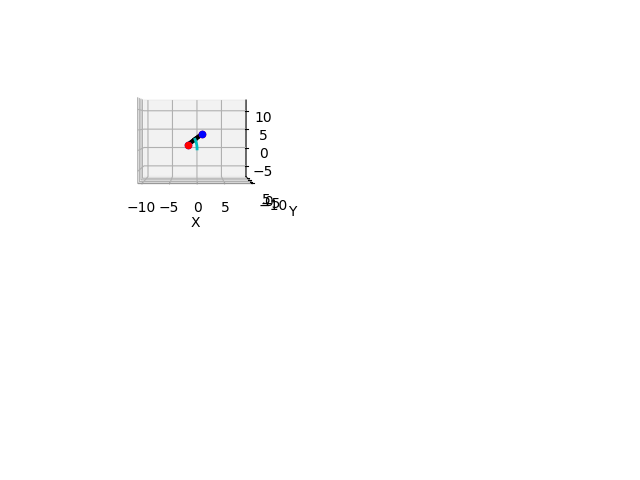

Ending at: 
	[-3.99980947e-01 -7.33027242e-05  2.48741539e+00]
	[-1.11984999e-03 -4.53505414e+01  6.61056056e-02]


In [24]:
ad = Aerial_Device(np.array([[2,2,0],[2,-2,0],[-2,-2,0],[-2,2,0]]),
                   np.array([[0.0,0.0,3*np.pi/4],[0.0,0.0,np.pi/4],[0.0,0.0,-np.pi/4],[0.0,0.0,-3*np.pi/4]]),
                   np.array([-1, 1, -1, 1]), 150, 5, -0.05)

renderer = Renderer(ad)
ad.set_throttle([50, 50, 45, 45])
print(f'Starting at: \n\t{ad.poseActual}\n\t{ad.refActual}')
for i in range(10):
    ad.update_odometry(t=0.05)
    
renderer.render()
print(f'Ending at: \n\t{ad.poseActual}\n\t{np.degrees(ad.refActual)}')